In [1]:
import numpy as np
import netCDF4 as nc
import random
import pysptools.distance as spdist
import matplotlib.pyplot as plt
from rasterio.plot import show
from sklearn.cluster import KMeans
from IPython.display import clear_output
from sklearn import metrics
import matplotlib.patches as mpatches
import math

In [2]:
img=nc.Dataset("EMIT_L2A_RFL_001_20230305T050148_2306403_005 (1).nc")

In [3]:
data=img.variables['reflectance']
data = np.array(data)
data.shape

(1760, 1242, 285)

## Specify the number of clusters

In [4]:
N = 4
# clusters
c = [[] for i in range(N)]
# random initial points
v = []
for i in range(N):
    v.append((random.randint(0,data.shape[0]),random.randint(0,data.shape[1])))
#cluster spectrals
arr = []
for i in range(N):
    arr.append(np.zeros(285))
arr = np.array(arr)

In [5]:
data_t=np.transpose(data,(2,0,1))
data_t.shape

(285, 1760, 1242)

In [6]:
for i in range(N):
    print("CENTROID "+str(i+1)+" : "+str(v[i]))

CENTROID 1 : (87, 979)
CENTROID 2 : (46, 1031)
CENTROID 3 : (973, 539)
CENTROID 4 : (1461, 508)


In [7]:
a=381
bands=[]
for i in range(285):
    bands.append(a+7.41*i)
# bands

In [8]:
epochs=10
e=0
while(e<epochs):
    print("PROGRESS: EPOCH ",e+1)
    c = [[] for i in range(N)]
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            sam = [0 for i in range(N)]
            if i%1000==0 and j%1000==0:
                print(i,",",j)
            pixel_value=data[i,j,:]
            if e==0:
                for k in range(N):
                    sam[k] = spdist.SAM(pixel_value,data[v[k][0],v[k][1],:])
            else:
                for k in range(N):
                    sam[k] = spdist.SAM(pixel_value,arr[k])
                
            ind=np.argmin(sam)

            for l in range(N):
                if ind == l:
                    c[l].append((i,j))    

    for a in range(len(c)):
        for b in range(len(c[a])):
            m,n = c[a][b]
            arr[a] = np.add(arr[a],data[m,n,:])
        arr[a] = arr[a]/len(c[a])
    
    e=e+1
    clear_output(wait=True)

PROGRESS: EPOCH  10
0 , 0
0 , 1000
1000 , 0
1000 , 1000


In [9]:
noise = np.where(arr[0]==np.amin(arr[0]))
noise

(array([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
        211, 212], dtype=int64),)

In [10]:
for i in range(127,142):
    for k in range(N):
        arr[k][i] = np.nan
for i in range(187,213):
    for k in range(N):
        arr[k][i] = np.nan

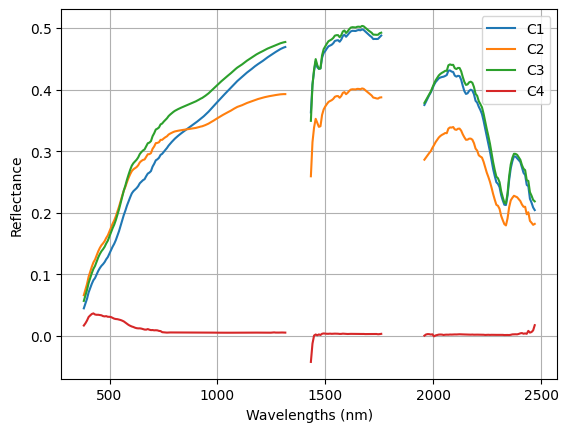

In [11]:
plt.plot(bands[:-2],arr[0][:-2])
plt.plot(bands[:-2],arr[1][:-2])
plt.plot(bands[:-2],arr[2][:-2])
plt.plot(bands[:-2],arr[3][:-2])
plt.grid()
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Reflectance")
plt.legend(["C1","C2","C3","C4"])
plt.savefig("Images/Spectral Reflectance - Yemen Coast.png",dpi=800)
plt.show()

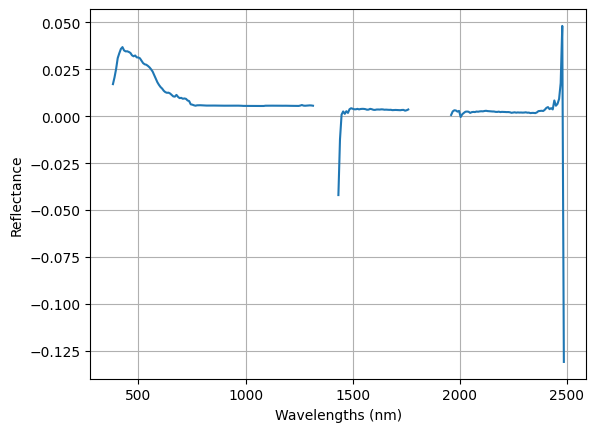

In [12]:
plt.grid()
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Reflectance")
plt.plot(bands,arr[3])
# plt.savefig("Images/Spectral Plot - Yemen Desert.png",dpi=3000)
plt.show()

In [28]:
clustered_img = np.zeros((data.shape[0],data.shape[1]))
j=0
value = math.ceil(256/N)
tmp = 256
for i in range(N):
    for j in c[i]:
        clustered_img[j[0],j[1]] = tmp
    tmp = tmp-value

In [21]:
clustered_img = clustered_img/256

In [16]:
clustered_img = np.zeros((data.shape[0],data.shape[1]))

# for i in c1:
#     clustered_img[i[0],i[1]] = 256
# for i in c2:
#     clustered_img[i[0],i[1]] = 128
# for i in c3:
#     clustered_img[i[0],i[1]] = 64
# for i in c4:
#     clustered_img[i[0],i[1]] = 0

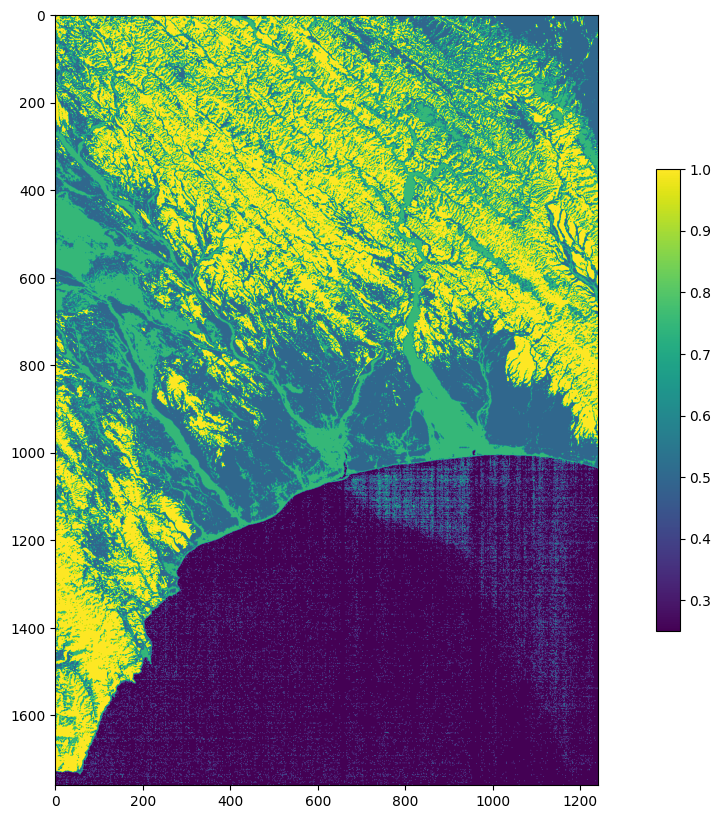

In [22]:
min = np.nanmin(clustered_img)
max = np.nanmax(clustered_img)
mid = 0.1

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
cbar_plot = ax.imshow(clustered_img,vmin = min,vmax = max)
# ax.axis('off')
cbar = fig.colorbar(cbar_plot, orientation='vertical', shrink=0.6)
# plt.savefig("Images/Clustered Image - Yemen Coast(colorbar)",dpi=800)
plt.show()

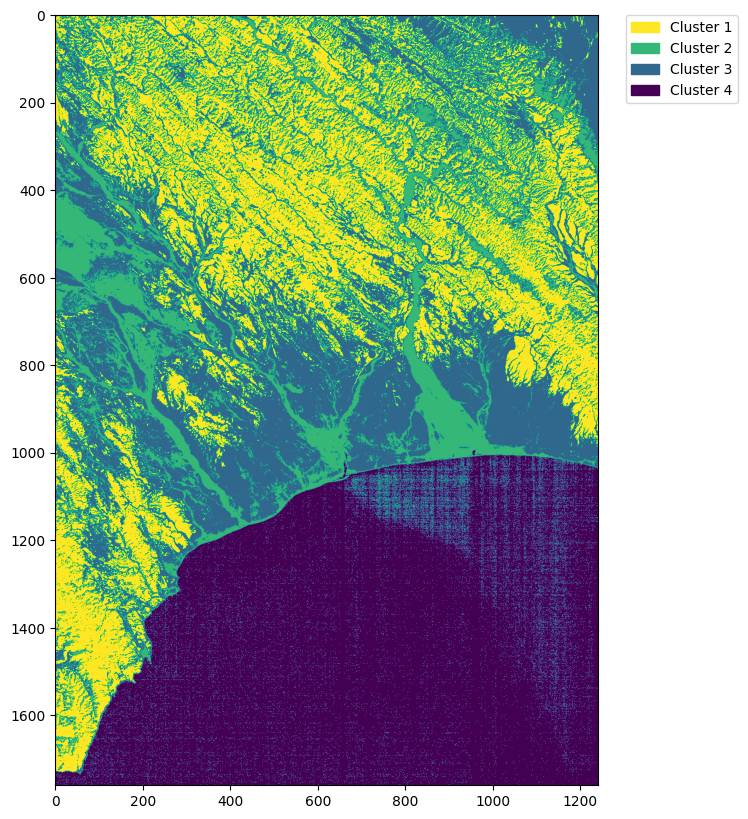

In [42]:
values = np.unique(clustered_img.ravel())
values = values[::-1]
clusters = [i+1 for i in range(N)]
fig = plt.figure(figsize=(15,10))
img = plt.imshow(clustered_img)
colors = [img.cmap(img.norm(value)) for value in values]
patches = [mpatches.Patch(color=colors[i], label="Cluster {0}".format(clusters[i])) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
# plt.savefig("Images/Clustered Image - Yemen Coast(legend)",dpi=800)
plt.show()

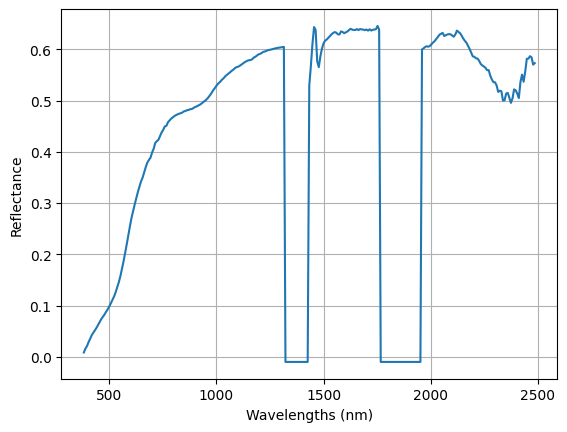

In [17]:
plt.grid()
plt.xlabel("Wavelengths (nm)")
plt.ylabel("Reflectance")
plt.plot(bands,data[1000,1000,:])
# plt.savefig("Images/Spectral Plot - Yemen Desert(1000,1000).png",dpi=3000)
plt.show()

### Silhoulette Index

In [34]:
dist_01,dist_02,dist_03,dist_12,dist_13,dist_23 = [0 for i in range(6)]
dist_01 = np.sum(np.square(arr[0]-arr[1]))
# dist_02 = np.sum(np.square(arr[0]-arr[2]))
# dist_03 = np.sum(np.square(arr[0]-arr[3]))
# dist_12 = np.sum(np.square(arr[1]-arr[2]))
# dist_13 = np.sum(np.square(arr[1]-arr[3]))
# dist_23 = np.sum(np.square(arr[2]-arr[3]))

# print(dist_01,dist_02,dist_03,dist_12,dist_13,dist_23)
b0 = np.min([dist_01])
# b0 = np.min([dist_01,dist_02,dist_03])
# b1 = np.min([dist_01,dist_12,dist_13])
# b2 = np.min([dist_02,dist_12,dist_23])
# b3 = np.min([dist_03,dist_13,dist_23])
print(b0)
# print(b1,b2,b3)

31.757897582776003


Cluster 1

In [35]:
num_points = 10000
r0 = []
for i in range(num_points): 
    val = (random.randint(0,len(c[0])))
    dist = np.sum(np.square(data[c[0][val][0]][c[0][val][1]]-arr[0]))
    r0.append(dist)
dist_r0 = np.average(r0)
print(dist_r0)

2.7631239985848217


In [37]:
sil0 = (b0-dist_r0)/(np.max([dist_r0,b0]))
print(sil0)

0.9129941145699957


In [14]:
print(dist_r0/b0)

9.190507272440307


Cluster 2

In [20]:
num_points = 10000
r2 = []
cluster = 2
# print(c[0][200,100])
# print(random.randint(0,len(c[0])))
for i in range(num_points): 
    val = (random.randint(0,len(c[cluster])))
    dist = np.sum(np.square(data[c[cluster][val][0]][c[cluster][val][1]]-arr[cluster]))
    r2.append(dist)
dist_r2 = np.average(r2)
print(dist_r2)

9.69647693032807


In [21]:
sil2 = (b2-dist_r2)/(np.max([dist_r2,b2]))
print(sil2)

-0.8805596505695814


Cluster 4

In [17]:
num_points = 10000
r3 = []
# print(c[0][200,100])
# print(random.randint(0,len(c[0])))
for i in range(num_points): 
    val = (random.randint(0,len(c[3])))
    dist = np.sum(np.square(data[c[3][val][0]][c[3][val][1]]-arr[3]))
    r3.append(dist)
dist_r3 = np.average(r3)
print(dist_r3)

1.0191480530552504


In [18]:
sil3 = (b3-dist_r3)/(np.max([dist_r3,b3]))
print(sil3)

-0.834582805885734


### Import Mineral Identification Data

In [2]:
img1=nc.Dataset("EMIT_L2B_MIN_001_20230528T093558_2314807_018.nc")

In [3]:
data1=img1.variables['group_2_mineral_id']
data1 = np.array(data1)
data1.shape

(1280, 1242)

In [18]:
uni_vals = np.unique(data1)
uni_vals

array([  0, 125, 126, 129, 130, 131, 132, 135, 138, 141, 143, 146, 148,
       151, 168, 191, 192, 193, 199, 200, 213, 215, 216, 220, 225, 226,
       227, 230, 234, 241, 242, 256, 263, 265, 267], dtype=int16)

In [79]:
uni_vals = np.unique(data1)
map = {}
for i in range(len(uni_vals)):
    map[i] = uni_vals[i]
# print(map)
for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        for k in range(len(uni_vals)):
            if data1[i,j] == uni_vals[k]:
                data1[i,j] = k
    print(i)
    clear_output(wait=True)

1279


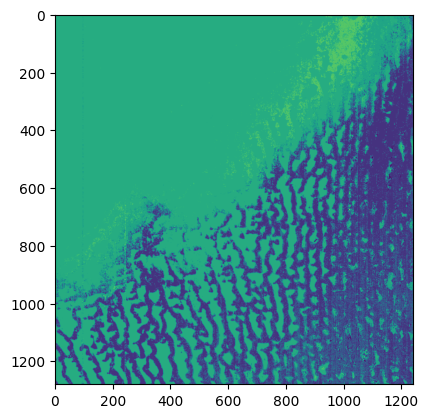

In [80]:
plt.imshow(data1)

In [81]:
print(data1.shape)
clustered_img.shape

(1280, 1242)


(1280, 1242)

In [4]:
metrics.silhouette_score(labels=clustered_img,X=data1[0])

NameError: name 'clustered_img' is not defined

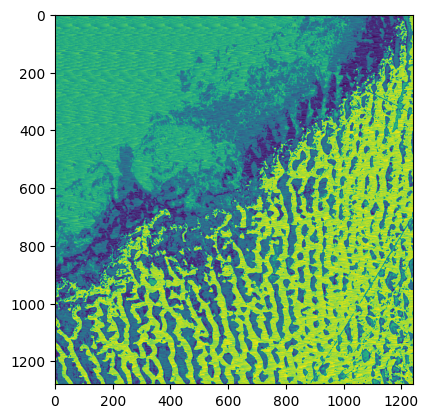

In [40]:
plt.imshow(clustered_img)

In [28]:
plt.cm.Bu

<module 'matplotlib.cm' from 'C:\\Users\\Manav\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\cm.py'>

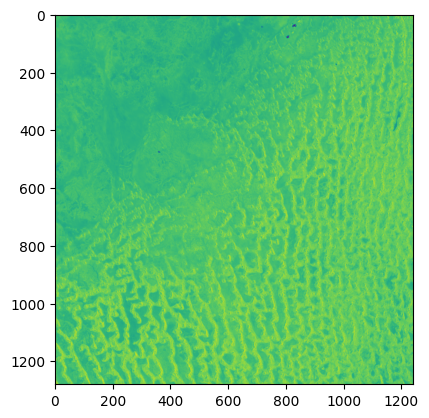

In [5]:
plt.imshow(data_t[100])

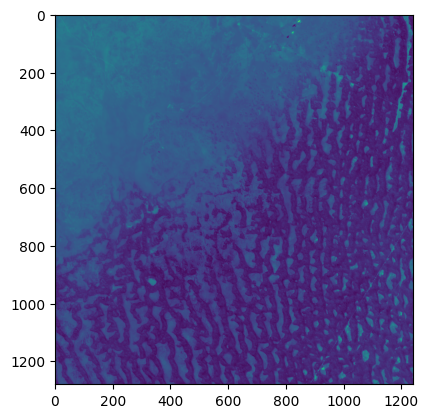

<Axes: >

In [6]:
show(data_t[10])

In [9]:
a=381
bands=[]
for i in range(285):
    bands.append(a+7.41*i)
# bands

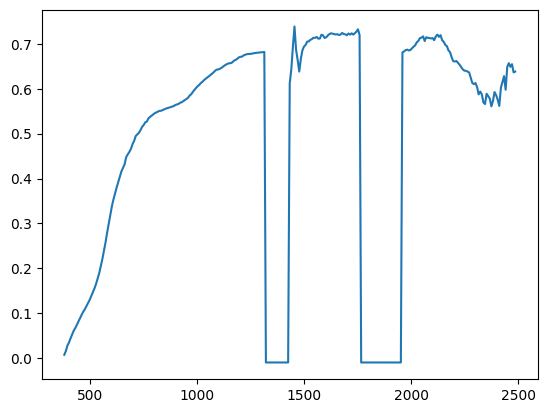

In [11]:
plt.plot(bands,data_t[:,1200,750])